# Calculating equilibrium mineral contents from a liquid line of descent
- Here, we are using the liquid results from a Petrolog3 fractional crystallizatoin model (Liu et al. in prep)
- Yes, you can get mineral compositions from Petrolog3 directly, but this allows you to use more up-to-date models for mineral compositions
- We wish to calculate the equilibrium An of Plag, Mg# of Cpx, and Fo of olivine at each step along the fractionation path, to compare to the mineral compositions we observe sulfides in.
- You can download the Excel spreadsheet here: https://github.com/PennyWieser/Thermobar/blob/main/docs/Examples/Mineral_Eq_Contents_from_LLD/Mineral_Sulfides_Together.xlsx

### First, pip install Thermobar if you haven't already

In [1]:
#!pip install Thermobar

In [2]:
import numpy as np
import pandas as pd
import Thermobar as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import warnings as w
pd.options.display.max_columns = None
from matplotlib import patches
print('Thermobar version')
print(pt.__version__)

Thermobar version
1.0.13


In [3]:
# Set some plotting parameters
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

### Import your liquid compositions extracted from Petrolog into the thermobar format

In [4]:
In=pt.import_excel('Model9_BaliOnlyLang_Closedsystem_32kbar_NiCu_02.xlsx', sheet_name='Thermobar_input')
In_all=In['my_input']
Liqs=In['Liqs']
Liqs['T_K']=In_all['Temperature']+273.15

### Check they have read in correctly

In [5]:
Liqs.head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq,T_K
0,48.8740,0.7872,16.3903,7.639650,0.1413,10.1312,14.0169,1.5745,0.0606,0.0505,0.0606,0.1514,0.099972,0.0,0.0,0.0,step1,1519.900
1,48.8315,0.7924,16.5133,7.681599,0.1427,10.0416,13.9595,1.5885,0.0612,0.0510,0.0612,0.1529,0.100422,0.0,0.0,0.0,step2,1516.869
2,48.7880,0.7977,16.6394,7.724217,0.1442,9.9486,13.9595,1.6030,0.0618,0.0515,0.0618,0.1545,0.100893,0.0,0.0,0.0,step3,1513.763
3,48.7442,0.8031,16.7661,7.766625,0.1457,9.8541,13.8460,1.6175,0.0624,0.0520,0.0624,0.1561,0.101373,0.0,0.0,0.0,step4,1510.643
4,48.6995,0.8085,16.8958,7.809603,0.1472,9.7561,13.7900,1.6325,0.0631,0.0526,0.0631,0.1577,0.101875,0.0,0.0,0.0,step5,1507.448


## An example of a specific application
- We have observed sulfides touching/enclosed within Plag, Cpx and Olivine grains. We have also modelled sulfide saturation, so we know the approximate MgO that sulfides should come on the liquidus (~8 wt%). 
- We want to work out at what approximate MgO each crystal grew. So if sulfides appear in Cpx compositions that are in equilibrium with 8 wt% MgO liquids, we know our sulfide saturation model works. If they appear in crystals that grew at 10 wt% MgO, we have predicted the onset of sulfide saturation a bit late. If they appear at 6 wt% MgO, its a bit early

### First, we read in the mineral data, each mineral has a sulfide next to it

In [6]:
Plags=pt.import_excel('Mineral_Sulfides_Together.xlsx', 
                      sheet_name='Plag_with_Sulf', suffix="_Plag").get('Plags')
Cpxs=pt.import_excel('Mineral_Sulfides_Together.xlsx', 
                     sheet_name='Cpx_with_Sulf', suffix="_Cpx").get('Cpxs')
Ols=pt.import_excel('Mineral_Sulfides_Together.xlsx', 
                    sheet_name='Ol_with_Sulf', suffix="_Ol").get('Ols')

# And matrix glasses
MG=pt.import_excel('Mineral_Sulfides_Together.xlsx', 
                   sheet_name='Matrix_Glasses', suffix="_Liq").get('Liqs')

### Then we calculate An contents, Mg#s, and Fo contents for these

In [7]:
Plag_An=pt.calculate_cat_fractions_plagioclase(plag_comps=Plags).get('An_Plag')
Cpx_Mgno=pt.calculate_cpx_mgno(cpx_comps=Cpxs)
Ol_Fo=pt.calculate_ol_fo(ol_comps=Ols)

### Calculate Glass Fe3FeT from redox (FMQ+0.2, Bali et al. 2018)

In [15]:
Fe3Fet_MG_calc=pt.convert_fo2_to_fe_partition(liq_comps=MG, T_K=Liqs['T_K'], P_kbar=3.2,
model="Kress1991", fo2="QFM", renorm=False, fo2_offset=0.2).get('Fe3Fet_Liq')

### Then we calculate Eq contents of each mineral for the matrix glasses

In [16]:
Eq_Plag_MG=pt.calculate_eq_plag_An_number(liq_comps=MG, P=3.2, T=Liqs['T_K'], An_model='All')


Eq_Ol_MG=pt.calculate_eq_ol_content(liq_comps=MG, Kd_model="All",T=Liqs['T_K'], P=3.2, Fe3Fet_Liq=Fe3Fet_MG_calc)


Eq_Cpx_MG=pt.calculate_eq_cpx_Mg_number(liq_comps=MG,  Kd_model="Putirka2008", T=Liqs['T_K'], Fe3Fet_Liq=Fe3Fet_MG_calc)


C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:2120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


## Vertically stacked graph with histograms on the side
- We can also display the models relative to real data as histograms on the side

In [22]:
An_Cores=pt.import_excel('Mineral_Sulfides_Together.xlsx', sheet_name='Plag_cores', suffix='_Plag').get('Plags')
An_content_Cores=pt.calculate_cat_fractions_plagioclase(plag_comps=An_Cores).get('An_Plag')
An_content_Cores

0    0.825676
1    0.756983
2    0.789329
Name: An_Plag, dtype: float64

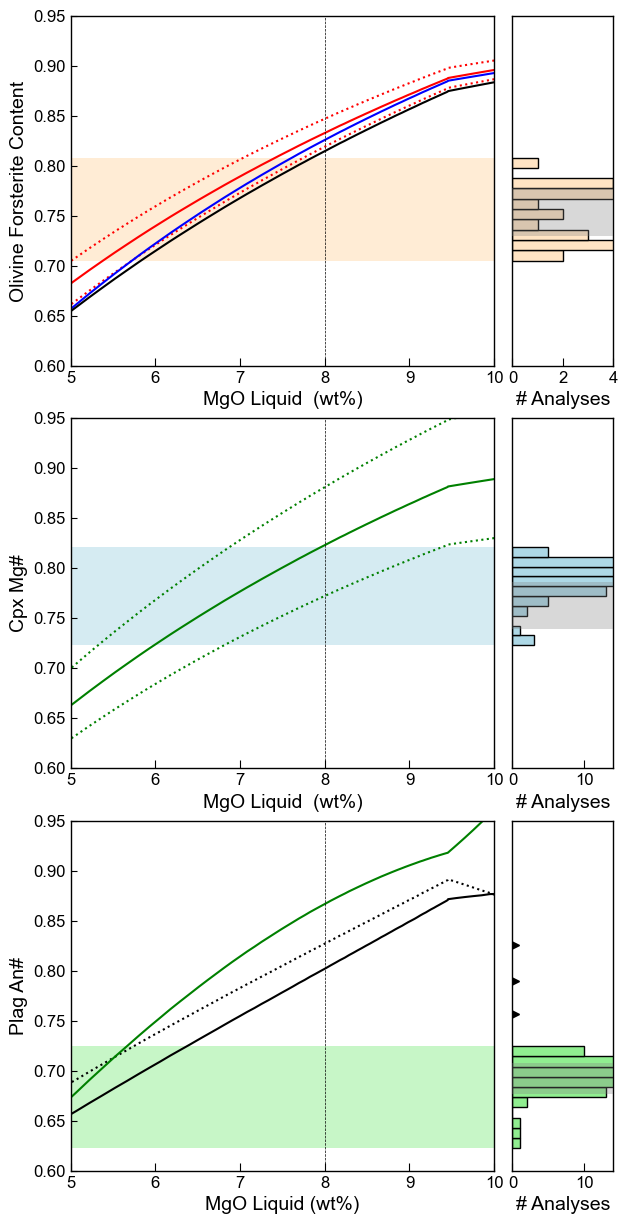

In [25]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig, (((ax1a),(ax1b)), ((ax2a), (ax2b)), ((ax3a), (ax3b))) = plt.subplots(3, 2,
                        figsize=(7,15),gridspec_kw={'width_ratios': [4.2, 1]}, sharey=True)
plt.subplots_adjust(wspace=0.07, hspace=0.15)
# xmin_MgO=np.min(MG['MgO_Liq'])
# xmax_MgO=np.max(MG['MgO_Liq'])
xmin_MgO=4
xmax_MgO=10

#################################

ax1a.plot(Liqs['MgO_Liq'], Eq_Ol_PET['Eq Fo (Roeder, Kd=0.3)'], '-r', label='RE1970, Kd=0.3')
ax1a.plot(Liqs['MgO_Liq'], Eq_Ol_PET['Eq Fo (Roeder, Kd=0.33)'], ':r', label='RE1970, Kd=0.3')
ax1a.plot(Liqs['MgO_Liq'], Eq_Ol_PET['Eq Fo (Roeder, Kd=0.27)'], ':r', label='RE1970, Kd=0.3')

ax1a.plot(Liqs['MgO_Liq'], Eq_Ol_PET['Eq Fo (Toplis, Iter)'], '-b', label='Toplis2005')
ax1a.plot(Liqs['MgO_Liq'], Eq_Ol_PET['Eq Fo (Matzen, Kd=0.34)'], '-k', label='Matzen201')
ymin_ol=np.nanmin(Ol_Fo)
ymax_ol=np.nanmax(Ol_Fo)
rect_ol=patches.Rectangle((xmin_MgO, ymin_ol), (xmax_MgO-xmin_MgO), (ymax_ol-ymin_ol), 
                           lw=1, ec="None", facecolor='bisque', alpha=0.7)
ax1a.add_patch(rect_ol)


#######################################
ymin_cpx=np.nanmin(Cpx_Mgno)
ymax_cpx=np.nanmax(Cpx_Mgno)
rect_cpx=patches.Rectangle((xmin_MgO, ymin_cpx), (xmax_MgO-xmin_MgO), (ymax_cpx-ymin_cpx), 
                           lw=1, ec="None", facecolor='lightblue', alpha=0.5)
ax2a.add_patch(rect_cpx)

ax2a.plot(Liqs['MgO_Liq'], Eq_Cpx_PET['Eq Mg# (Putirka 2008, Fet)'],
         '-g', label='Putirka (2005) eq.35')
ax2a.plot(Liqs['MgO_Liq'], Eq_Cpx_PET['Eq Mg# (Putirka 2008 +0.08, Fet)'],
         ':g', label='Putirka (2005)+0.08, eq.35')
ax2a.plot(Liqs['MgO_Liq'], Eq_Cpx_PET['Eq Mg# (Putirka 2008 -0.08, Fet)'],
         ':g', label='Putirka (2005)-0.08, eq.35')


ax2a.yaxis.set_tick_params(which='both', labelbottom=True)

###############################################

ymin_plag=np.nanmin(Plag_An)
ymax_plag=np.nanmax(Plag_An)
rect_plag=patches.Rectangle((xmin_MgO, ymin_plag), (xmax_MgO-xmin_MgO), (ymax_plag-ymin_plag), 
                           lw=1, ec="None", facecolor='lightgreen', alpha=0.5)
ax3a.add_patch(rect_plag)

ax3a.plot(Liqs['MgO_Liq'], Eq_Plag_PET['An_Eq_Thermo_eq31_N2011'],
         '-k', label='Namur 2011 Thermo model')
ax3a.plot(Liqs['MgO_Liq'], Eq_Plag_PET['An_Eq_best_non-thermo_choice_N2011'],
         ':k', label='Namur 2011 Non-thermo model')
ax3a.plot(Liqs['MgO_Liq'], Eq_Plag_PET['Pred_An_EqE_P2005'],
         '-g', label='Putirka 2005 EqE')

ax3b.plot(0*An_content_Cores, An_content_Cores, '>k', ms=10, zorder=100)
ax3a.yaxis.set_tick_params(which='both', labelbottom=True)
###########################################################################
# Plot mineral compositions on LHS axis. 
# Make a patch of the minimum and maximum An for measured matrix glasses
plag_model='An_Eq_best_non-thermo_choice_N2011'

ymin_plag=np.min(Eq_Plag_MG[plag_model])
ymax_plag=np.max(Eq_Plag_MG[plag_model])
xmin_plag=0
xmax_plag=15
rect_plag=patches.Rectangle((xmin_plag, ymin_plag), (xmax_plag-xmin_plag), (ymax_plag-ymin_plag), 
                           lw=1, ec="None", facecolor='grey', alpha=0.3, zorder=100)
ax3b.add_patch(rect_plag)

# Histogram of measured Plag An contents
ax3b.hist(Plag_An, fc='lightgreen', ec='k', orientation='horizontal')




# Make a patch of the minimum and maximum Mgno for measured matrix glasses
cpx_model='Eq Mg# (Putirka 2008, Fe2)'
ymin_cpx=np.min(Eq_Cpx_MG[cpx_model])
ymax_cpx=np.max(Eq_Cpx_MG[cpx_model])
xmin_cpx=0
xmax_cpx=15
rect_cpx=patches.Rectangle((xmin_cpx, ymin_cpx), (xmax_cpx-xmin_cpx), (ymax_cpx-ymin_cpx), 
                           lw=1, ec="None", facecolor='grey', alpha=0.3, zorder=100)
ax2b.add_patch(rect_cpx)


ax2b.hist(Cpx_Mgno, fc='lightblue',  orientation='horizontal', ec='k')



ol_model='Eq Fo (Roeder, Kd=0.3)'

ymin_ol=np.min(Eq_Ol_MG[ol_model])
ymax_ol=np.max(Eq_Ol_MG[ol_model])
xmin_ol=0
xmax_ol=15
rect_ol=patches.Rectangle((xmin_ol, ymin_ol), (xmax_ol-xmin_ol), (ymax_ol-ymin_ol), 
                           lw=1, ec="None", facecolor='grey', alpha=0.3, zorder=100)
ax1b.add_patch(rect_ol)

ax1b.hist(Ol_Fo, fc='bisque',  orientation='horizontal', ec='k')


# Hide RHS axes

#ax1b.axes.get_xaxis().set_visible(False)
ax1b.axes.get_yaxis().set_visible(False)
#ax2b.axes.get_xaxis().set_visible(False)
ax2b.axes.get_yaxis().set_visible(False)
#ax3b.axes.get_xaxis().set_visible(False)
ax3b.axes.get_yaxis().set_visible(False)

# set all a axis 
ax1a.set_xlim([5, 10])
ax2a.set_xlim([5, 10])
ax3a.set_xlim([5, 10])
# set single a y axis
ax1a.set_ylim([0.6, 0.95])
# Setting b x axis
ax1b.set_xlim([0, 4])
ax2b.set_xlim([0, 14])
ax3b.set_xlim([0, 14])
ax1b.set_ylim()
###

ax3a.set_xlabel('MgO Liquid (wt%)')
ax3a.set_ylabel('Plag An#')
#ax3a.legend(loc='upper left')

ax2a.set_xlabel('MgO Liquid  (wt%)')
ax2a.set_ylabel('Cpx Mg#')
#ax2a.legend()

ax1a.set_xlabel('MgO Liquid  (wt%)')
ax1a.set_ylabel('Olivine Forsterite Content')
#ax1a.legend()
ax1b.set_xlabel('# Analyses')
ax2b.set_xlabel('# Analyses')
ax3b.set_xlabel('# Analyses')

ax1a.plot([8, 8], [0.6, 1], '--k', zorder=100, lw=0.5)
ax2a.plot([8, 8], [0.6, 1], '--k', zorder=100, lw=0.5)
ax3a.plot([8, 8], [0.6, 1], '--k', zorder=100, lw=0.5)
fig.savefig('Mineral_Equilirium.png', dpi=300)
fig.savefig('Mineral_Equilibrium_010222.pdf', dpi=300)